This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

Update the John Holkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [19]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [20]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'CAN',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

The "data date" is 2020-06-26 00:00:00

ADF Statistic: -1.339123
p-value: 0.611089
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


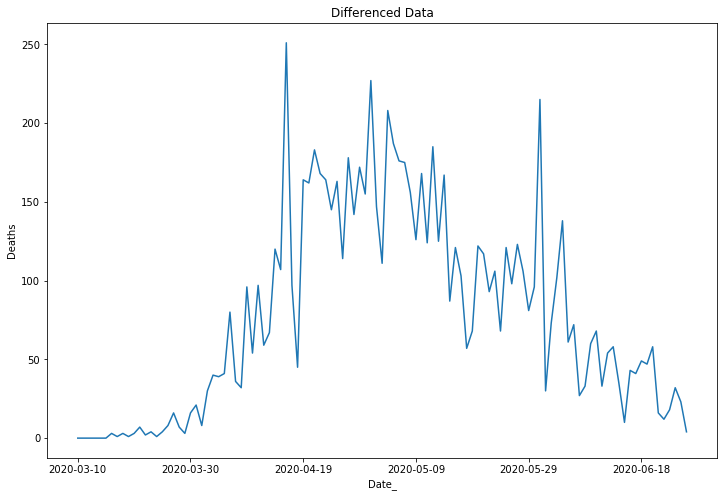

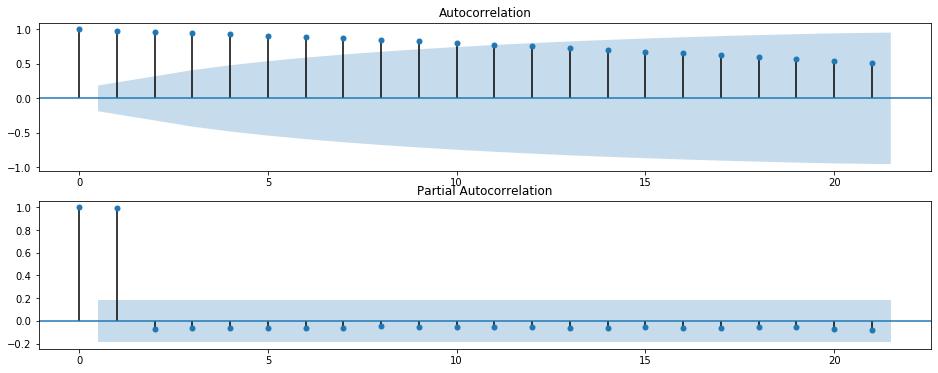

ARIMA(0, 0, 1) RMSE=3511.842
ARIMA(0, 1, 1) RMSE=76.572
ARIMA(0, 1, 2) RMSE=62.854
ARIMA(0, 2, 1) RMSE=35.732
ARIMA(0, 2, 2) RMSE=36.056
ARIMA(1, 0, 0) RMSE=104.514
ARIMA(1, 1, 0) RMSE=44.367
ARIMA(1, 2, 0) RMSE=40.443
ARIMA(1, 2, 1) RMSE=35.994


In [ ]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

In [ ]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [ ]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

In [ ]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()